# **Signed Cumulative Distribution Transform (SCDT)**

Authors:
Sumati Thareja,
D.M. Rocio,
Ivan Medri,
Akram Aldroubi,
Gustavo Rohde,

In [1]:
import numpy as np
from numpy import interp
import math
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy import signal

import sys
sys.path.append('../')
from pytranskit.optrans.continuous import SCDT
#from scdt import *

**Examples**
This code demonstrates the following,

*   Example of Generalized Inverse
*   Forward and inverse operations of the SCDT
*   SCDT Properties - translation, scaling
*   Linear separability in SCDT space
 



# **Generalized Inverse**

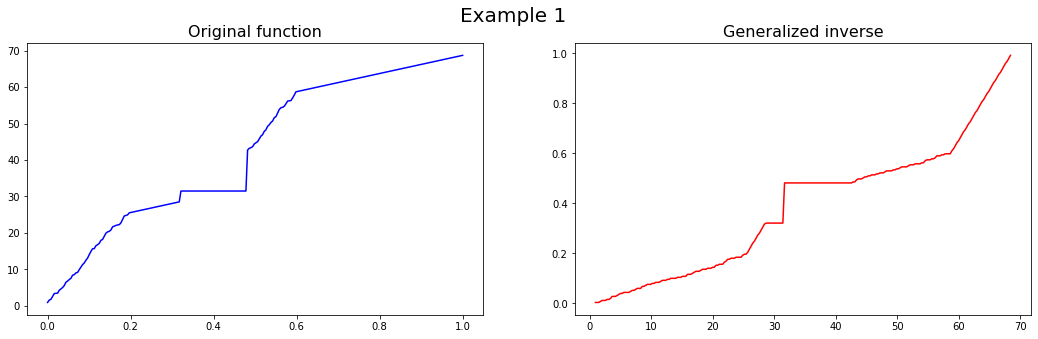

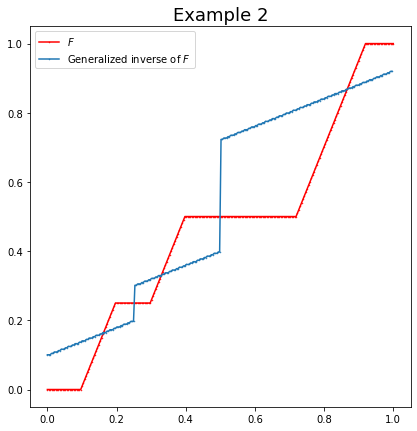

In [2]:
### EXAMPLE 1

## Create a non-decreasing function F
N = 250
t0 = np.linspace(0, 1, N)
F = (1.0/10)*np.ones(N)
F[0:50] = np.random.rand(50)
F[100:150] = np.random.rand(50)
F = np.cumsum(F)
F[80:120] = F[100]*np.ones(40)

## Perform its Generalized Inverse
cdt = SCDT(F) 

dom_geninv = np.linspace(F[0],F[-1],N)  
F_inv = cdt.gen_inverse(F,t0,dom_geninv)

## Plotting 
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18,5))
fig.suptitle('Example 1', fontsize=20, color='black')
ax[0].plot(t0,F, 'b-')
ax[0].set_title("Original function",
          fontsize=16, color='black')
ax[1].plot(dom_geninv,F_inv, 'r-')
ax[1].set_title("Generalized inverse",
         fontsize=16, color='black')
plt.show()


### EXAMPLE 2

#Generating the function to invert
Domain_F = t0

## dF is density function
dF = np.zeros(N)
dF[25:50] = 0.01
dF[75:100]= 0.01
dF[180:230]= 0.01
## F is the cumulative of dF
F = np.cumsum(dF)

## Inverting the function
Domain_geninvF = np.linspace(F[0],F[-1],N)
Inv_F = cdt.gen_inverse(F,Domain_F,Domain_geninvF)

## Plotting
plt.figure(figsize=(7,7))    
plt.plot(Domain_F,F, color="red", linestyle="-", marker='.',markersize=1, label='$F$')
plt.plot(Domain_geninvF,Inv_F, linestyle="-", marker='.',markersize=1, label = 'Generalized inverse of $F$')
plt.title('Example 2', fontsize=18, color='black')
plt.legend()
plt.axis('scaled')
plt.show()



**Reference Density $s_0$**

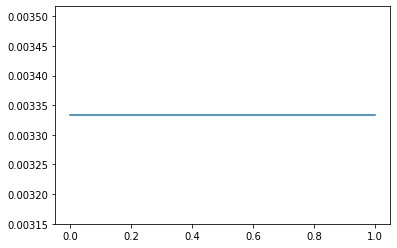

In [3]:
N = 300

## Gaussian distribution
t0 = np.linspace(0,1,N) # Domain of the reference
#s0 = np.exp(-10*(t0-0.5)**2)/np.sqrt(2*np.pi)
s0 = np.ones(N)
s0 = s0/s0.sum()

scdt = SCDT(reference=s0)

plt.plot(t0,s0)
plt.show()

**Target signal $s$**

for example $\quad $ $s(t) = \pi^{-0.25}e^{4\pi j \omega (t-0.5)}e^{-120(t-0.5)^2} $ 

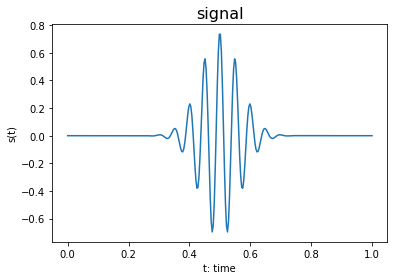

In [4]:
t = np.linspace(0,1.0,N) # Domain of the target signal

def signal_gabor(t):
    w = 10
    tm = t[-1]/2
    s = np.real(math.pi**-0.25 * np.exp(4*math.pi*1j*w*(t-tm)) * np.exp(-120*((t-tm)**2)))
    return s

s = signal_gabor(t)
s_CDF = np.cumsum(s)
# Plotting
plt.plot(t, s)
plt.title("signal",
          fontsize=16, color='black')
plt.xlabel('t: time')
plt.ylabel('s(t)')
plt.show()

**Compute SCDT transform of $s$ & the inverse transform**

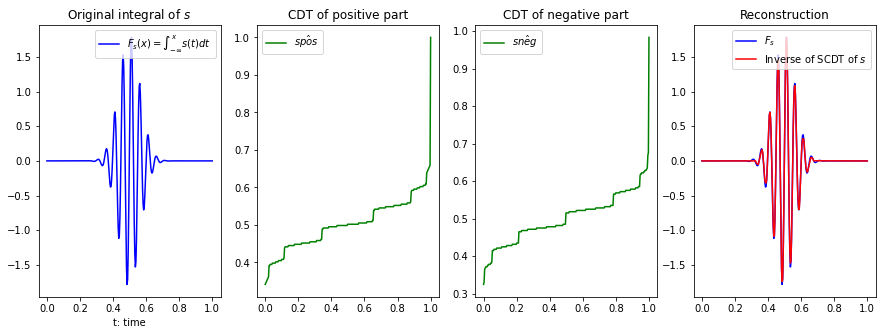

In [5]:
#Calculating SCDT of the target signal
##spos,sneg contain transform of the positve and negative parts of s
### smasspos, smassneg contain the masses of the positive and negative parts of s
spos, sneg, smasspos, smassneg = scdt.stransform(s)

fig, ax = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(15,5))
ax[0].plot(t, np.cumsum(s), 'b-')
ax[0].set_xlabel('t: time')
ax[0].set_title('Original integral of $s$')
ax[0].legend(['$F_s(x)=\int_{-\infty}^x s(t)dt$'])

ax[1].plot(t0, spos, 'g-')
ax[1].set_title('CDT of positive part')
ax[1].legend(['$\hat{spos}$'])

ax[2].plot(t0, sneg, 'g-')
ax[2].set_title('CDT of negative part')
ax[2].legend(['$\hat{sneg}$'])

ax[3].plot(t, np.cumsum(s), 'b-')
ax[3].plot(t, scdt.istransform(spos, sneg, smasspos, smassneg), 'r-')
ax[3].set_title('Reconstruction')
ax[3].legend(['$F_s$','Inverse of SCDT of $s$'])

plt.show()

## **Class: Translation and Dilation**

In [6]:
class ACTIONS:
    def translate(self,I,mu):
        """
        translate makes the translation of a signal by a parameter of displacement
        input:
            I: the signal
            mu: the parameter of translation
        output:
            The translation of the signal I by mu
        """
        x = np.arange(len(I))
        Itranslate = interp(x-mu, x,I)
        return Itranslate
    
    def dilate(self,I,sigma):
        """
        dilate makes the dilation or compression of a signal by a given parameter 
        input:
            I: the signal
            sigma: the parameter of dilation or compression 
        output:
            The dilation or compression of the signal I by sigma
        """
        x = np.arange(len(I))
        Idilate = interp (x*sigma, x, I)
        return Idilate*sigma

**Translation property of SCDT**

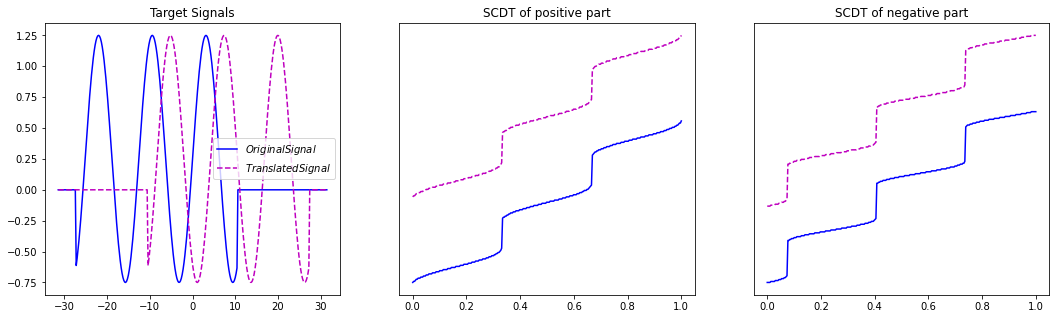

In [7]:
## Target density
x = np.linspace(-10*np.pi,10*np.pi,N)
I = np.sin(x/2) + 0.25
window = np.zeros(N)
window[20:N-100] = np.ones(N-120)
I = I*window

##Translation of the target density
act = ACTIONS()
mu = 80
I1 = act.translate(I,mu)

##SCDT of the target density 
Ipos, Ineg, Imasspos, Imassneg = scdt.stransform(I)

##SCDT of a translation of the target density 
I1pos, I1neg, I1masspos, I1massneg = scdt.stransform(I1)

#Plot of SCDTs of the target signal and its translation

fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(18,5))
ax[0].plot(x, I, 'b-')
ax[0].plot(x, I1, 'm--')
ax[0].set_title('Target Signals')
#ax[0].set_yticks([])
ax[0].legend([r'$Original Signal$',r'$Translated Signal$'])

ax[1].plot(t0,Ipos, 'b-')
ax[1].plot(t0,I1pos, 'm--')
ax[1].set_yticks([])
ax[1].set_title('SCDT of positive part')

ax[2].plot(t0, Ineg, 'b-')
ax[2].plot(t0, I1neg, 'm--')
ax[2].set_yticks([])
ax[2].set_title('SCDT of negative part')

plt.show()

**Dilation Property of SCDT**

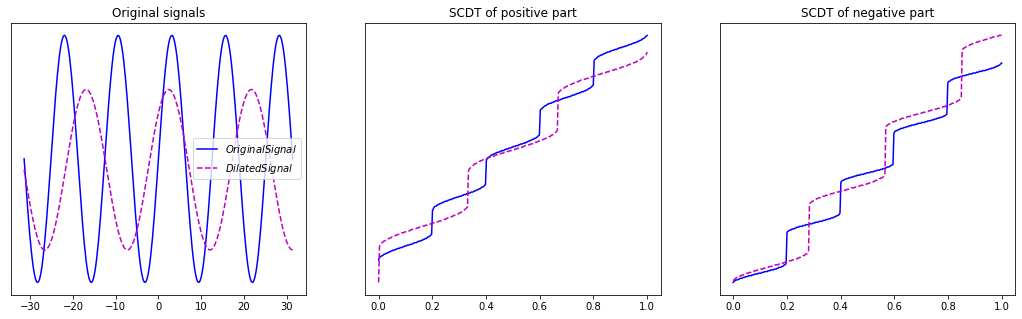

In [8]:
## Target density
y = np.linspace(-10*np.pi,10*np.pi,N)
J = np.sin(y/2) + 0.25

## Dilation of the target density
act = ACTIONS()
sigma = 0.65
J1 = act.dilate(J,sigma) 

##SCDT of the target density 
Jpos, Jneg, Jmasspos, Jmassneg = scdt.stransform(J)

##SCDT of a dilation of the target density 
J1pos, J1neg, J1masspos, J1massneg = scdt.stransform(J1)

#Plot of SCDTs of the target signal and its dilation

fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(18,5))

ax[0].plot(y, J, 'b-')
ax[0].plot(y, J1, 'm--')
ax[0].set_title('Original signals')
ax[0].set_yticks([])
ax[0].legend([r'$Original Signal$',r'$Dilated Signal$'])

ax[1].plot(t0,Jpos, 'b-')
ax[1].plot(t0,J1pos, 'm--')
ax[1].set_yticks([])
ax[1].set_title('SCDT of positive part')

ax[2].plot(t0,Jneg, 'b-')
ax[2].plot(t0,J1neg, 'm--')
ax[2].set_yticks([])
ax[2].set_title('SCDT of negative part')

plt.show()

# **Linear separability**

Test linear separability of three classes, i.e. class  𝑘∈{1,2,3}
k
∈
{
1
,
2
,
3
}
 , Gabor, Sawtooth, Square apodized wave. Use only translation and scaling.

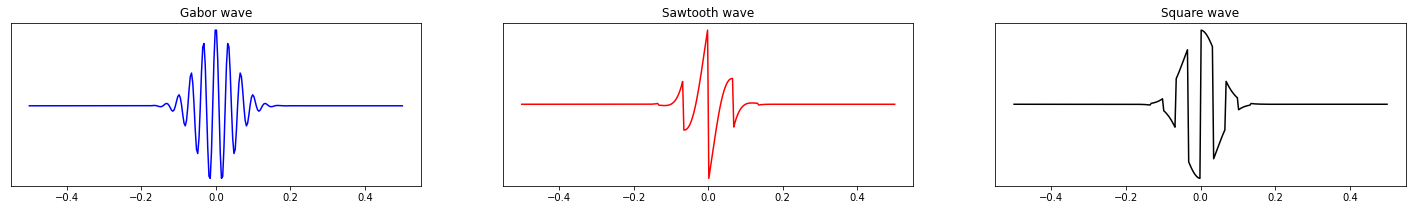

In [9]:
## Define a set of signals
N = 300
t = np.linspace(-0.5,0.5,N)


def signal_gabor(t):
    w = 30
    s = np.real(math.pi**-0.25 * np.exp(2*math.pi*1j*w*(t)) * np.exp(-200*((t)**2)))
    return s

def signal_sawtooth(t):
    s2 = signal.sawtooth(2 * np.pi * 15 * t)* np.exp(-250*((t)**2))
    return s2

def signal_square(t):
    s3 = signal.square(2 * np.pi * 15 * t)*np.exp(-250*((t)**2))
    return s3

s1 = signal_gabor(t) 

s2 = signal_sawtooth(t) 

s3 = signal_square(t) 

## Plotting
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(25,3))

#c = ['b*', 'ro', 'kx'][i]
ax[0].plot(t,s1,'b')
ax[0].set_title("Gabor wave")
ax[0].set_yticks([])

ax[1].plot(t,s2,'r')
ax[1].set_title("Sawtooth wave")
ax[1].set_yticks([])

ax[2].plot(t,s3,'k')
ax[2].set_title("Square wave")
ax[2].set_yticks([])

plt.show()




In [10]:
K = 3 # number of classes
L_slope = 20 # number of slope variations
L_shift = 30 # number of shifts
L = L_slope*L_shift
# N number of points in each signal

I = np.zeros((K,L,N))
Ihat = np.zeros((K,L,2*(N+1))) #we are going to store both positive and negative parts of the SCDT together by concatenating them
slope_array = np.linspace(0.75,2,L_slope)
shift_array = np.linspace(-0.25,0.25,L_shift)


#populate gabor class
k = 0
v = 0
for i_slope in range(L_slope):
    for i_shift in range(L_shift):
            b = slope_array[i_slope]
            c = shift_array[i_shift]
            g = b*(t) + c
            g_prime = b
            s =  g_prime*signal_gabor(g) 
            s = s/1
            noise = np.random.normal(0.0,0.02,N)
            I[k,v,:] = s + noise
            Ipos, Ineg, Imasspos, Imassneg = scdt.stransform(s+noise)
            Ipos_mass = np.array([Imasspos])
            Ineg_mass = np.array([Imassneg])
            Ipos_final = np.concatenate((Ipos,Ipos_mass),axis=0)
            Ineg_final = np.concatenate((Ineg,Ineg_mass),axis=0)
            Ihat[k,v,:]= np.concatenate((Ipos_final,Ineg_final),axis=0)
            v = v+1
        
#populate sawthoot class
k = 1
v = 0
for i_slope in range(L_slope):
    for i_shift in range(L_shift):
        b = slope_array[i_slope]
        c = shift_array[i_shift]
        g = b*(t) + c
        g_prime = b
        s =  g_prime*signal_sawtooth(g) 
        s = s/1
        noise = np.random.normal(0.0,0.02,N)
        I[k,v,:] = s + noise
        Ipos, Ineg, Imasspos, Imassneg = scdt.stransform(s+noise)
        Ipos_mass = np.array([Imasspos])
        Ineg_mass = np.array([Imassneg])
        Ipos_final = np.concatenate((Ipos,Ipos_mass),axis=0)
        Ineg_final = np.concatenate((Ineg,Ineg_mass),axis=0)
        Ihat[k,v,:]= np.concatenate((Ipos_final,Ineg_final),axis=0)
        v = v+1

#populate square wave class
k = 2
v = 0
for i_slope in range(L_slope):
    for i_shift in range(L_shift):
        b = slope_array[i_slope]
        c = shift_array[i_shift]
        g = b*(t) + c
        g_prime =  b
        s =  g_prime*signal_square(g) 
        s = s/1
        noise = np.random.normal(0.0,0.02,N)
        I[k,v,:] = s + noise
        Ipos, Ineg, Imasspos, Imassneg = scdt.stransform(s+noise)
        Ipos_mass = np.array([Imasspos])
        Ineg_mass = np.array([Imassneg])
        Ipos_final = np.concatenate((Ipos,Ipos_mass),axis=0)
        Ineg_final = np.concatenate((Ineg,Ineg_mass),axis=0)
        Ihat[k,v,:]= np.concatenate((Ipos_final,Ineg_final),axis=0)
        v = v+1
        

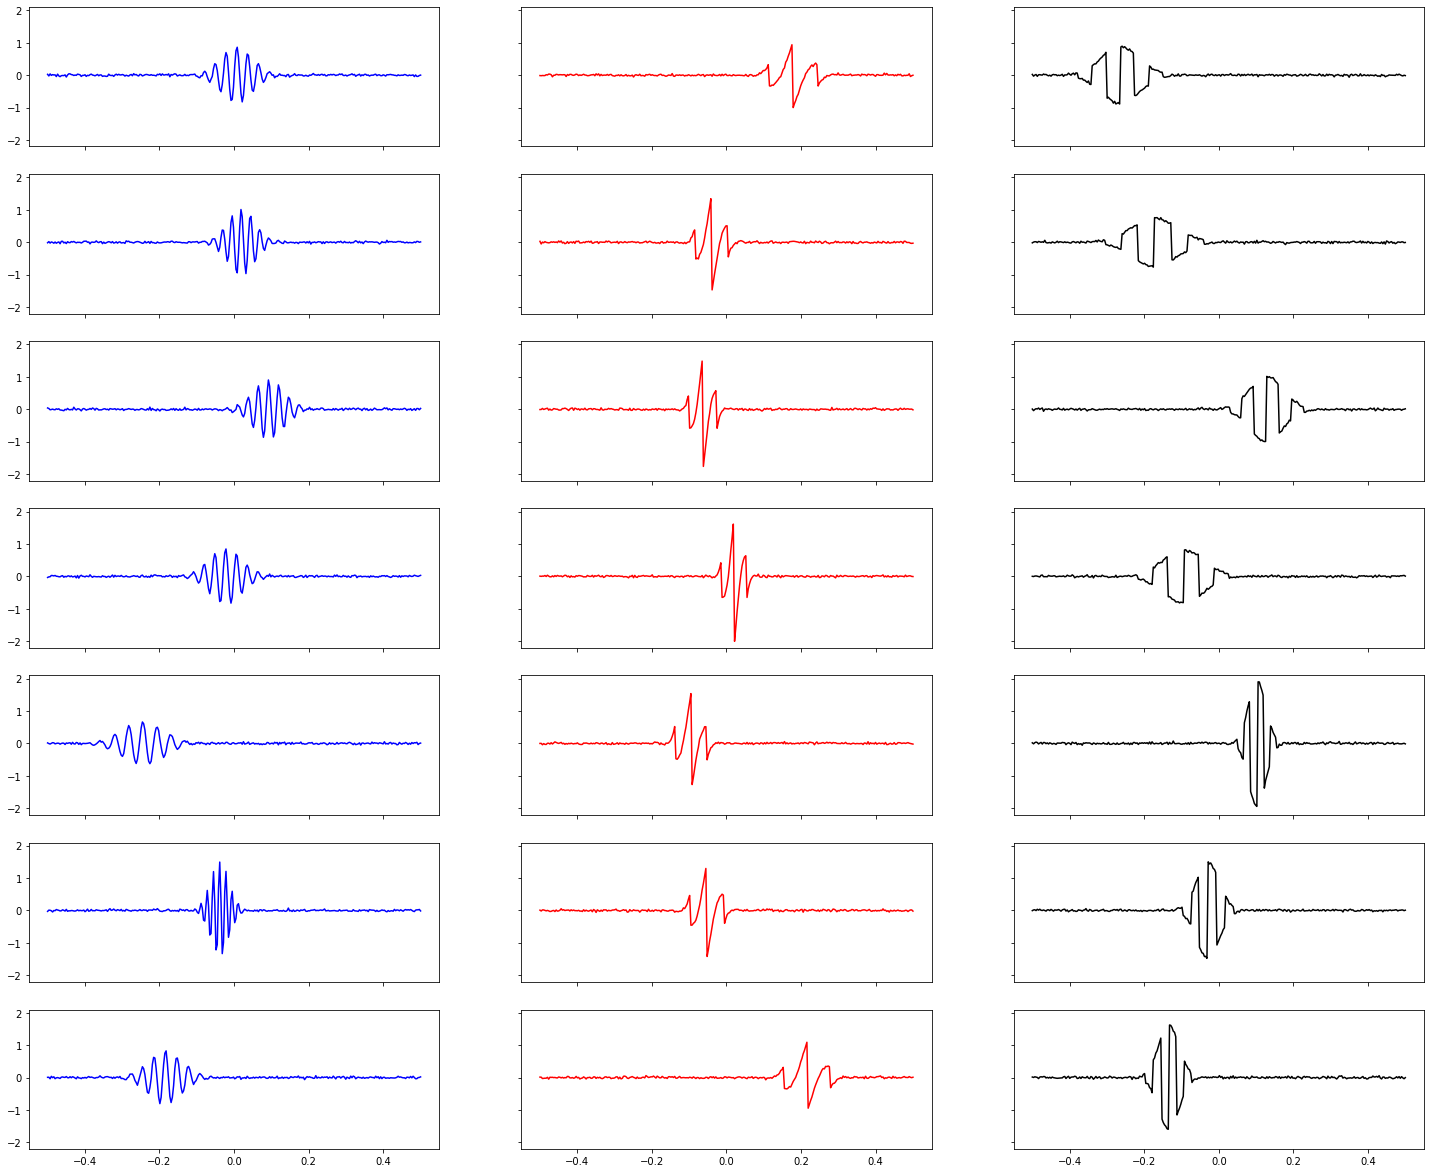

In [11]:
import random
N_plots = 7
SNRdb = [10.]

index_array = np.zeros((3,N_plots),dtype=int)
index_array[0,:] = random.sample(range(0, L_slope*L_shift), N_plots)
index_array[1,:] = random.sample(range(0, L_slope*L_shift), N_plots)
index_array[2,:] = random.sample(range(0, L_slope*L_shift), N_plots)

## Plotting
fig, axs = plt.subplots(N_plots, 3, sharex=True, sharey=True, figsize=(25,3*N_plots))
color_array = ['b','r','k']
for k in range(3):
    for p in range(N_plots):
        v = index_array[k,p]
        s = I[k,v,:]
        axs[p,k].plot(t,s,color_array[k])
    

plt.show()

Test accuracy in signal space: 0.31777777777777777
Test accuracy in transform space: 0.9933333333333333


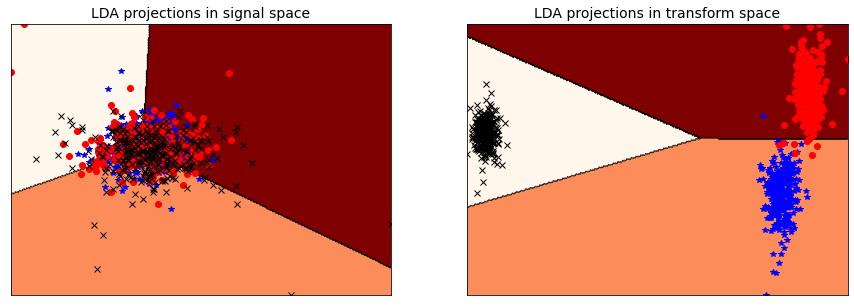

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

fontSize=14

X=np.reshape(I,(K*L,N))      #Combine the signals into a features vector X
Xhat=np.reshape(Ihat,(K*L,2*(N+1)))     #Combine the transformed signals into a features vector Xhat
label=np.concatenate((np.zeros(L,),np.ones(L,),-1*np.ones(L,))) # Define the labels as -1,0,1 for the three classes
label = label.astype(np.int)
#split traning and testing data
data_train, data_test, label_train, label_test = train_test_split(X, label, test_size=0.5, random_state=42)

lda=LinearDiscriminantAnalysis(n_components=2)
svm=LinearSVC()

fig,ax=plt.subplots(1,2,figsize=(15,5))

dataLDA=lda.fit_transform(data_train,label_train)
dataLDA_test = lda.transform(data_test)

print("Test accuracy in signal space:",lda.score(data_test, label_test) )

for i in range(3):
    l = [0, 1, -1][i]
    c = ['b*', 'ro', 'kx'][i]
    ax[0].plot(dataLDA_test[label_test==l,0],dataLDA_test[label_test==l,1],c)

x_min, x_max = dataLDA_test.min(axis=0)[0], dataLDA_test.max(axis=0)[0]
y_min, y_max = dataLDA_test.min(axis=0)[1], dataLDA_test.max(axis=0)[1]
nx, ny = 400, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),np.linspace(y_min, y_max, ny))
svm.fit(dataLDA,label_train)
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:].reshape(xx.shape)
ax[0].pcolormesh(xx, yy, Z,cmap='OrRd')
ax[0].contour(xx, yy, Z, linewidths=.5, colors='k')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("LDA projections in signal space",fontsize=fontSize)
    
    
    
lda=LinearDiscriminantAnalysis(n_components=2)
svm=LinearSVC()
data_train_h, data_test_h, label_train, label_test = train_test_split(Xhat, label, test_size=0.5, random_state=42)

dataLDAh=lda.fit_transform(data_train_h,label_train)
dataLDA_test_h = lda.transform(data_test_h)
print("Test accuracy in transform space:",lda.score(data_test_h, label_test) )

for i in range(3):
    l = [0, 1, -1][i]
    c = ['b*', 'ro', 'kx'][i]
    ax[1].plot(dataLDA_test_h[label_test==l,0],dataLDA_test_h[label_test==l,1],c)
    
x_min, x_max = dataLDA_test_h.min(axis=0)[0], dataLDA_test_h.max(axis=0)[0]
y_min, y_max = dataLDA_test_h.min(axis=0)[1], dataLDA_test_h.max(axis=0)[1]
nx, ny = 400, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),np.linspace(y_min, y_max, ny))
svm.fit(dataLDAh,label_train)
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:].reshape(xx.shape)
ax[1].pcolormesh(xx, yy, Z,cmap='OrRd')
ax[1].contour(xx, yy, Z, linewidths=.5, colors='k')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("LDA projections in transform space",fontsize=fontSize)

plt.show()